In [ ]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix
from math import *
from collections import Counter
from sklearn.decomposition import TruncatedSVD
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import scipy.spatial.distance
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

with open("train.dat", "r") as fh1:
    train_lines = fh1.readlines()

# print train_lines

docs = [l.split() for l in train_lines]

print "docs" , len(docs)
indptr = [0]
data = []
indices = []
# print docs[0][1]
ptr = 0
new_ptr = 0
for j in range(len(docs)):

    for i in range(len(docs[j])):

        if i % 2 == 0:
            indices.append((docs[j][i]))
        else:
            new_ptr = new_ptr + 1
            data.append((docs[j][i]))

    indptr.append(new_ptr)

print "indices", len(indices)
print "data", len(data)
print "indptr", len(indptr)

data_np = np.array(data, dtype=np.float)
indices_np = np.array(indices, dtype=np.int)
indptr_np = np.array(indptr, dtype=np.int)

new_data = data_np.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(new_data)
new_data = new_data.flatten()

print "maximum index", np.amax(indices_np)
# print "last indptr", indptr_np[-1], "first indptr", indptr[-1]- indptr[-2], " len data", len(docs[-1])/2

cols = np.unique(indices_np).shape[0]
mat = csr_matrix ((new_data, indices_np, indptr_np), shape=(len(docs), np.amax(indices_np)), dtype=np.float)
mat.sort_indices()
print "mat", mat.shape

svd = TruncatedSVD(n_components= 100, algorithm = 'arpack')
train_transformed = svd.fit_transform(mat)
print train_transformed.shape


def connected_components(sims, d,p,  eps, min_pts, k, cluster_list):

    pt_detection, neigh = compute_neighborhood(sims, eps,  p, min_pts)

    if pt_detection == 1:
        cluster_list[p] = k
        for n in neigh:
            cluster_list[n] = k
            i = 0
            while i < len(neigh):
                if neigh[i] == p and (i < len(neigh)-1):
                    i = i + 1
                new_p = neigh[i]
                new_pt_detection, new_neigh = compute_neighborhood(sims, eps, new_p, min_pts)
                if new_pt_detection == 1:
                    for new_n in new_neigh:
                        if cluster_list[new_n] == 0 or cluster_list[new_n] == -2 or cluster_list[new_n] == -3:
                            cluster_list[new_n] = k
                i = i+1
        return True
    elif pt_detection == 2:
        cluster_list[p] = -2 #border point
        return False

    elif pt_detection == 3:
        cluster_list[p] = -3  # for noise point
        return False
    else:
        return False


def compute_neighborhood(sims, eps, p, min_pts):

    # for n in (min_pts+1):
    x = np.where(sims[p, :] > eps) #finding cosine similarity between all points and p is greater than eps
    if len(x[0]) > min_pts:
        y = np.asarray(x).flatten()
        return 1, y #core point

    elif 0 < len(x[0]) <= min_pts:
        y = np.zeros(1)
        return 2, y #border point

    else:
        y = np.zeros(1)
        return 3, y  #noise point

def post_processing(cluster_list, sims):
    temp_cluster_list = cluster_list
    for i in range(len(temp_cluster_list)):
        if temp_cluster_list[i] < 1:
            sim_i= sims[i, :]
            sims_i_np = np.asarray(sim_i).flatten()
            new_sims_i_np = np.delete(sims_i_np, i)
            max_sim = np.argmax(new_sims_i_np)
            temp_cluster_list[i] = temp_cluster_list[max_sim]

    return temp_cluster_list

d = train_transformed
sims = cosine_similarity(d) #calculating pairwise cosine similarity between all documents
def dbscan(min_pts):   
    eps = 0.5
    cluster_list = [0] * (d.shape[0])
    k = 1    
#     print "sims shape", sims.shape
    "DBSCAN Algorithm"
    for p in range(d.shape[0]):
        if cluster_list[p] == 0:
            detection = connected_components(sims, d,p,  eps, min_pts, k, cluster_list)
            if detection == True:
                k = k + 1
    new_cluster_list = post_processing(cluster_list, sims)
    return new_cluster_list



docs 8580
indices 1107980
data 1107980
indptr 8581
maximum index 126355
mat (8580, 126355)
(8580, 100)


In [2]:
"Determining the radius Eps for MinPts varying from 3 to 21 in steps of 2 for the given dataset."
all_sims = []
all_sims = np.sort(sims, axis = 0)
index = []
for i in range(d.shape[0]):
    index.append(i)
    

In [3]:
def plot_graph(pts):
    graph_distance = []
    graph_distance = all_sims[:, 0:pts]
    plt.plot(index, graph_distance)
    plt.xlabel('total text documents')
    plt.ylabel('sorted cosine similarities between documents')
    plt.title('Eps-MinPts Determination')
    plt.grid(linestyle='dotted')
    plt.show()
    

Graph for 3  nearest neighbors


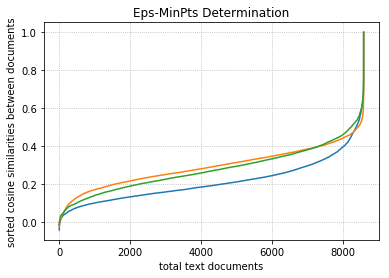

Graph for 5  nearest neighbors


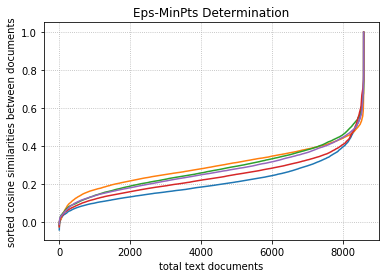

Graph for 7  nearest neighbors


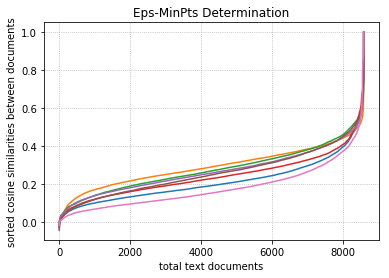

Graph for 9  nearest neighbors


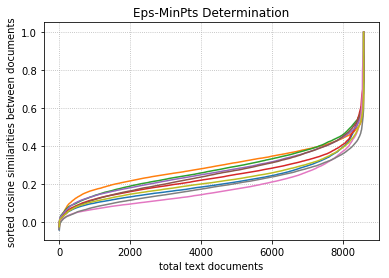

Graph for 11  nearest neighbors


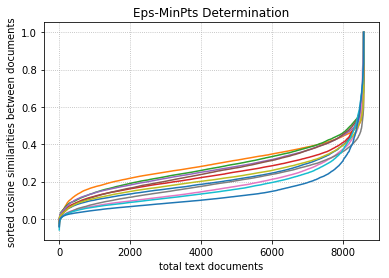

Graph for 13  nearest neighbors


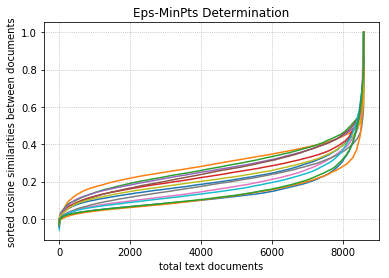

Graph for 15  nearest neighbors


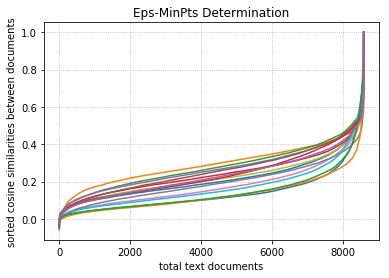

Graph for 17  nearest neighbors


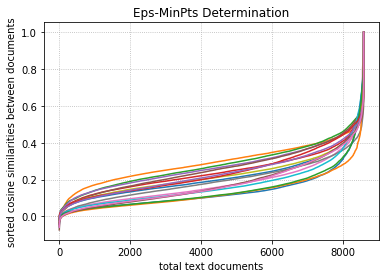

Graph for 19  nearest neighbors


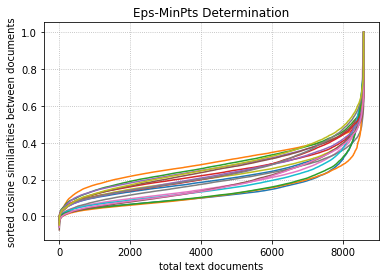

Graph for 21  nearest neighbors


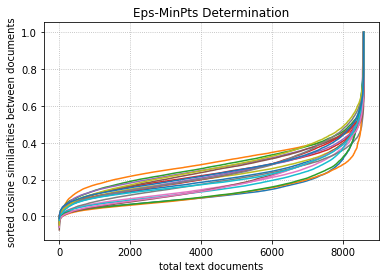

In [6]:
sil_score = []
pts_graph = []
for pts in xrange(3, 22 , 2):
    print "Graph for", str(pts), " nearest neighbors"
    plot_graph(pts)
    if pts == 5:
        new_cluster_list = dbscan(min_pts = 5)
        output = open('pre_processed_predictions-eps_0.5_minpts_5_final.dat', 'w')

        output.writelines( "%s\n" % int(prediction) for prediction in new_cluster_list )

        output.close()
        sil_score.append(silhouette_score(d, new_cluster_list))
        pts_graph.append(pts)
        
    else:     
        cluster_labels = dbscan(pts)
        sil_score.append(silhouette_score(d, cluster_labels))
        pts_graph.append(pts)
    
    

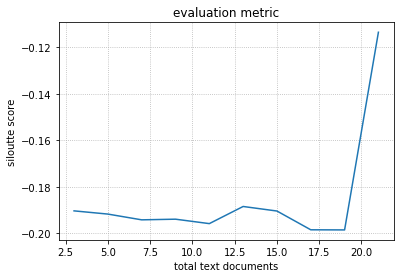

In [7]:
plt.plot(pts_graph, sil_score)
plt.xlabel('total text documents')
plt.ylabel('siloutte score')
plt.title('evaluation metric')
plt.grid(linestyle='dotted')
plt.show()

In [8]:
sil_score

[-0.19030085621627432,
 -0.19167998609828163,
 -0.19415043414788238,
 -0.19387035667498823,
 -0.19577299398430267,
 -0.18841793361435427,
 -0.190368463337072,
 -0.19842318996080627,
 -0.19847585240608842,
 -0.1136422217149301]